# Prediction Task:
## _Predict bike rental demand as a function of suitable features available in or derived from the data sets_

## Libraries and styles

In [1]:
# importing all relevant libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime, timedelta
from haversine import haversine, Unit
from matplotlib.dates import date2num

In [2]:
# set seaborn styles
sns.set()
sns.set_style("whitegrid")
sns.set_palette("rocket")

# set pandas display styles
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 2000)
pd.set_option('display.max_rows', 500)
%config IPCompleter.greedy=True

## Reading Function

In [3]:
def read_data(city_name):
    trip_data = pd.read_csv("Project_Data/Combined_Data/"+city_name+".csv", encoding = "ISO-8859-1")
    trip_data["trip_duration"] = pd.to_timedelta(trip_data["trip_duration"])
    trip_data["datetime_start"] = pd.to_datetime(trip_data["datetime_start"])
    trip_data["datetime_end"] = pd.to_datetime(trip_data["datetime_end"])
    trip_data["time"] = pd.to_datetime(trip_data["time"])
    trip_data["day"] = pd.to_datetime(trip_data["day"])
    return trip_data

In [4]:
dataBr = read_data("Bremen")
dataDu = read_data("Duesseldorf")

In [5]:
city1 = "Bremen"
city2 = "Duesseldorf"
start_date = "2019-02-01 00:00:00"
end_date = "2019-06-30 23:59:00"
startDate = datetime.fromisoformat(start_date)
endDate = datetime.fromisoformat(end_date)

In [6]:
# coordinates of city center as [lat, lng]
br_center = [53.078893247451994, 8.8027747491885]
du_center = [51.226815497281706, 6.773786392066722]

In [7]:
dataBr["distance_from_center_start"] = dataBr.apply(lambda row: haversine((row["orig_lat"], row["orig_lng"]),(br_center[0], br_center[1]),Unit.KILOMETERS), axis=1) 
dataBr["distance_from_center_end"] = dataBr.apply(lambda row: haversine((row["dest_lat"], row["dest_lng"]),(br_center[0], br_center[1]),Unit.KILOMETERS), axis=1) 
dataDu["distance_from_center_start"] = dataDu.apply(lambda row: haversine((row["orig_lat"], row["orig_lng"]),(du_center[0], du_center[1]),Unit.KILOMETERS), axis=1) 
dataDu["distance_from_center_end"] = dataDu.apply(lambda row: haversine((row["dest_lat"], row["dest_lng"]),(du_center[0], du_center[1]),Unit.KILOMETERS), axis=1) 

***

## Data for Prediction Task

### Prepare data
Since we have data sets with single entries (trips) at one specific point of time, it does not make sense to take a value from the single entries as a target (since there is no "rental demand" associated with a single trip). Rather, we have to group the trips by a time unit, e.g. hour or day, and aggregate the number of trips per time unit, so there is a target associated with our data that can be predicted.

In [8]:
dataBr.head()

,Unnamed: 0,day,time,b_number,city,trip_duration,orig_lat,orig_lng,dest_lat,dest_lng,...,fleetsize_monthly,distance,trip_duration_hours,avg_speed,rounded_time_hourly,temp,wind,rain,distance_from_center_start,distance_from_center_end
0,0,2019-04-21,2021-02-02 17:34:00,20507,bremen,00:13:00,53.078923,8.884911,53.078711,8.899906,...,395,1.001900,0.216667,4.624155,2019-04-21 18:00:00,20.4,2.0,0.0,5.486415,6.488083
1,1,2019-05-23,2021-02-02 15:33:00,20507,bremen,00:07:00,53.078923,8.884911,53.078004,8.876828,...,373,0.549476,0.116667,4.709793,2019-05-23 16:00:00,20.7,2.4,0.0,5.486415,4.947560
2,2,2019-06-14,2021-02-02 22:30:00,20507,bremen,00:08:00,53.078923,8.884911,53.074731,8.876003,...,342,0.755886,0.133333,5.669146,2019-06-14 22:00:00,19.6,4.4,0.0,5.486415,4.913475
3,3,2019-06-16,2021-02-02 10:00:00,20507,bremen,02:02:00,53.074731,8.876003,53.078923,8.884911,...,342,0.755886,2.033333,0.371747,2019-06-16 10:00:00,21.6,3.0,0.0,4.913475,5.486415
4,4,2019-06-16,2021-02-02 12:55:00,20507,bremen,02:23:00,53.078923,8.884911,53.076236,8.891322,...,342,0.522213,2.383333,0.219110,2019-06-16 13:00:00,21.8,4.4,0.0,5.486415,5.922224


#### Drop columns that are obviously neither relevant nor useful

In [9]:
dBr = dataBr.drop(["Unnamed: 0","b_number","day","time","city","fleetsize_weekly","fleetsize_dayly","fleetsize_monthly"], axis=1)
dDu = dataDu.drop(["Unnamed: 0","b_number","day","time","city","fleetsize_weekly","fleetsize_dayly","fleetsize_monthly"], axis=1)

In [10]:
# group the trips by either hour or day
def process_data_for_city(data, city, start_date, end_date, group):
    '''
    Processes given data and calculates the revenue per hour for a given city in a given time window. Also groups by 
    a given param (hour or day)

    :param data: the dataFrame of a given city
    :param city: a city in string format, e.g. "Bremen" or "Duesseldorf"
    :param start_date: an iso format time string, e.g. "2019-03-28 12:00:00"
    :param end_date: an iso format time string, e.g. "2019-03-31 12:00:00"
    :param group: a string, either "hour" or "day"
    '''

    # sorting of data
    dat = data.sort_values(by=['datetime_start'], axis=0)
 
    def calc_revenue(x):
        '''
        Counts trip duration intervals for each trip, i.e. how much revenue each trip generated,
        by setting the revenue to the number of 30-minute durations fitting into the trip duration,
        and add 1 to the revenue if division of trip duration by 30-minute interval has a remainder
        
        Examples: 
        If a trip was 30 mins long: trip duration / 30 mins --> revenue = 1 
        If a trip was 1 hour 12 mins long: trip duration / 30 mins = 2, remainder = 12 --> revenue = 2+1 = 3
        
        :param x: a trip/row
        '''
        if (x % pd.Timedelta(minutes=30)) > pd.Timedelta(minutes=0):
            return float(math.floor(x / pd.Timedelta(minutes=30) + 1))
        else:
            return float(math.floor(x / pd.Timedelta(minutes=30)))
                              
    # apply calculation to each row
    dat["revenue_per_trip"] = dat["trip_duration"].apply(lambda x: calc_revenue(x))

    # select rows in the given time window
    dat_time_framed = dat.loc[(dat["datetime_start"] > startDate) & (dat["datetime_start"] <= endDate)]
    
    
    # Group data in the given time window by month, day and hours to get to specific hourly level
    # and aggregate on several columns
    times = pd.DatetimeIndex(dat_time_framed.datetime_start)
    grouping = [times.month, times.day, times.hour] if group == "hour" else  [times.month, times.day]
    groupedBy = dat_time_framed.groupby(grouping).agg(trips_per_time=("datetime_start","count"), revenue_per_time=("revenue_per_trip","sum"), avg_temp=("temp","mean"), avg_wind=("wind","mean"), avg_rain=("rain","mean"), avg_distance=("distance","mean"), avg_dist_from_center_start=("distance_from_center_start","mean"), avg_dist_from_center_end=("distance_from_center_end","mean"))
   
    # reset index to get the groupedBy values back as columns
    groupedBy.index.rename(["month", "day", "hour"] if group == "hour" else ["month","day"], inplace=True)
    groupedBy.reset_index(inplace=True)
    
    # generate string date column
    groupedBy["date"] = "2019-" + groupedBy["month"].astype(str) + "-" +  groupedBy["day"].astype(str) + " 00:00:00"

    # generate datetime column for checking of weekdays and remove string date column
    groupedBy["datetime"] = [pd.to_datetime(d) for d in groupedBy.date]
    groupedBy.drop(["date"], axis=1, inplace=True)

    # generate weekday column for later use
    groupedBy["weekday"] = [dt.weekday() for dt in groupedBy.datetime]
    groupedBy.drop(["datetime"], axis=1, inplace=True)


    # check, if date is weekday (.weekday() returns 0 for a monday, and 6 for a sunday)
    groupedBy["is_weekday"] = groupedBy["weekday"] <=4
    groupedBy.drop(["weekday"], axis=1, inplace=True)
    
    # function determining the peak time; col1 (weekdays) at rush hour time and col2(weekend) spread over the noon/afternoon
    def isPeaktime(col1, col2):
        if ( ((col1 == True) and (col2 in (5,6,7,8,15,16,17))) or ((col1 == False) and (col2 in (10,11,12,13,14,15,16)))):
            return True
        else: 
            return False
    
    # function determining dark hours; based on col1(hour)
    def isDark(col1):
        if col1 > 19 or col1 < 6:
            return True
        else: 
            return False
        
    # function determining rainy hours
    def isRainy(col1):
        if col1 > 0.3:
            return True
        else: 
            return False
        
    # function determining windy hours
    def isWindy(col1):
        if col1 >= 8:
            return True
        else: 
            return False
        
    groupedBy["is_peaktime"] = groupedBy.apply(lambda row: isPeaktime(row.is_weekday, row.hour), axis=1)
    groupedBy["is_dark"] = groupedBy.apply(lambda row: isDark(row.hour), axis=1)
    groupedBy["is_rainy"] = groupedBy.apply(lambda row: isRainy(row.avg_rain), axis=1)
    groupedBy["is_windy"] = groupedBy.apply(lambda row: isWindy(row.avg_wind), axis=1)
    
    return groupedBy

In [11]:
TIME_FRAME="hour"

In [12]:
br = process_data_for_city(dBr, city1, startDate, endDate, TIME_FRAME)
du = process_data_for_city(dDu, city2, startDate, endDate, TIME_FRAME) 

***
## Correlation Analysis

The goal is to select those features (from the set of all features) that are optimally least correlated with each other and highly correlated with the target. As a guideline we could take a boundary correlation value of 0.3 or -0.3 to detect very low correlation and take at least low to medium correlation into consideration. However, some features with low correlation values still might be valuable for the prediction task, and a low correlation value might not filter those out (e.g. wind strength obviously has an impact on driven distance). As a result, all features with correlation below between 0.05 and -0.05 are considered not correlated with each other and are assumed to be able to be independently used in a feature set. The same values apply to selecting those features correlated with the target. However, correlation with the target should be maximized.

https://journals.sagepub.com/doi/pdf/10.1177/875647939000600106
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3576830/

#### on unprepared data

In [13]:
# showing the highest correlation values for a given data set with a given correlation metric
# disregards values equal to 1 at the diagonal
def show_high_corr(data, posMin, negMin, corr_method):
    corr = data.corr(method=corr_method)
    corr_val = np.array(corr)
    rows, cols = corr.shape
    flds = list(corr.columns)
    high_corr = []
    
    for i in range(cols):
        for j in range(i, cols):
            if corr_val[i,j] > posMin or corr_val[i,j] < negMin:
                if(i!=j):
                    high_corr.append([flds[i], flds[j], corr_val[i,j]])
    df = pd.DataFrame(high_corr, columns = ['col1', 'col2', 'correlation'])
    return df

In [14]:
# BREMEN, PEARSON CORRELATION
all_br_pe = show_high_corr(dBr, 0.05, -0.05, "pearson")
all_br_pe

,col1,col2,correlation
0,orig_lat,orig_lng,-0.070743
1,orig_lat,dest_lat,0.666620
2,orig_lat,dest_lng,-0.069857
3,orig_lat,distance,0.098017
4,orig_lat,trip_duration_hours,0.056897
5,orig_lat,distance_from_center_end,-0.064568
6,orig_lng,dest_lat,-0.066708
7,orig_lng,dest_lng,0.642663
8,orig_lng,distance,0.050057
9,orig_lng,distance_from_center_start,0.519234


In [15]:
# BREMEN, SPEARMAN CORRELATION
all_br_sp = show_high_corr(dBr, 0.05, -0.05, "spearman")
all_br_sp

,col1,col2,correlation
0,orig_lat,dest_lat,0.455863
1,orig_lat,distance,0.060518
2,orig_lat,trip_duration_hours,0.050182
3,orig_lng,dest_lng,0.516679
4,orig_lng,distance_from_center_start,0.557024
5,orig_lng,distance_from_center_end,0.316041
6,dest_lat,hour,-0.065336
7,dest_lat,distance,0.056946
8,dest_lng,hour,0.088366
9,dest_lng,distance_from_center_start,0.317261


##### Bremen
- geo coordinates have a strong positive correlation with each other
- geo coordinates have a strong positive correlation with distance from city center

**-->** remove geo coordinates or take only one out of those features with geo coordinates / distance from center

- month, hour and week are highly positively correlated with temp

**-->** try maybe with one out of [month,day,hour] plus temperature (e.g. since both hour and temp could be a valuable feature), or only temperature, or only time values

- distance is highly correlated with trip duration in hours, average speed

**-->** here, take only one feature, since they all rely on each other


**lower correlation values that still might be relevant**
- distance is negatively correlated with wind
- trip duration is positively correlated with wind
- avg speed is negatively correlated with temperature
- temperature is negatively correlated with rain
- weekday is positively correlated with trip duration and negatively correlated with average speed

In [16]:
# DÜSSELDORF, PEARSON CORRELATION
all_du_pe = show_high_corr(dDu, 0.05, -0.05, "pearson")
all_du_pe

,col1,col2,correlation
0,orig_lat,orig_lng,-0.111232
1,orig_lat,dest_lat,0.720237
2,orig_lat,dest_lng,-0.098727
3,orig_lat,month,-0.115170
4,orig_lat,week,-0.127535
5,orig_lat,distance,0.218181
6,orig_lat,trip_duration_hours,0.064961
7,orig_lat,avg_speed,0.072530
8,orig_lat,temp,-0.107898
9,orig_lat,distance_from_center_start,0.114302


In [17]:
# DÜSSELDORF, SPEARMAN CORRELATION
results_du_sp = show_high_corr(dDu, 0.05, -0.05, "spearman")
results_du_sp

,col1,col2,correlation
0,orig_lat,orig_lng,-0.112720
1,orig_lat,dest_lat,0.625418
2,orig_lat,dest_lng,-0.104434
3,orig_lat,month,-0.178435
4,orig_lat,week,-0.195161
5,orig_lat,distance,0.127378
6,orig_lat,trip_duration_hours,0.102637
7,orig_lat,temp,-0.133824
8,orig_lat,distance_from_center_end,-0.075555
9,orig_lng,dest_lat,-0.111214


##### Düsseldorf
- similar to Bremen


#### on prepared data

In [18]:
# BREMEN, PEARSON CORRELATION
prep_br_pe = show_high_corr(br, 0.05, -0.05, "pearson")
prep_br_pe

,col1,col2,correlation
0,month,trips_per_time,0.338867
1,month,revenue_per_time,0.329102
2,month,avg_temp,0.687527
3,month,avg_wind,-0.113449
4,month,avg_distance,0.151357
5,month,avg_dist_from_center_start,0.053164
6,month,avg_dist_from_center_end,0.075282
7,month,is_windy,-0.177736
8,day,trips_per_time,0.117279
9,day,revenue_per_time,0.126385


In [19]:
# BREMEN, SPEARMAN CORRELATION
prep_br_sp = show_high_corr(br, 0.05, -0.05, "spearman")
prep_br_sp

,col1,col2,correlation
0,month,trips_per_time,0.315185
1,month,revenue_per_time,0.319983
2,month,avg_temp,0.697175
3,month,avg_wind,-0.077939
4,month,avg_distance,0.174323
5,month,avg_dist_from_center_start,0.137824
6,month,avg_dist_from_center_end,0.145631
7,month,is_windy,-0.178611
8,day,trips_per_time,0.119769
9,day,revenue_per_time,0.124775


In [20]:
# DÜSSELDORF, PEARSON CORRELATION
prep_du_pe = show_high_corr(du, 0.05, -0.05, "pearson")
prep_du_pe

,col1,col2,correlation
0,month,trips_per_time,0.519501
1,month,revenue_per_time,0.468922
2,month,avg_temp,0.608237
3,month,avg_wind,-0.145120
4,month,avg_distance,-0.075954
5,month,avg_dist_from_center_start,-0.090167
6,month,avg_dist_from_center_end,-0.098002
7,month,is_weekday,-0.053011
8,month,is_peaktime,-0.119233
9,month,is_dark,0.126424


In [21]:
# DÜSSELDORF, SPEARMAN CORRELATION
prep_du_sp = show_high_corr(du, 0.05, -0.05, "spearman")
prep_du_sp

,col1,col2,correlation
0,month,trips_per_time,0.567465
1,month,revenue_per_time,0.520294
2,month,avg_temp,0.633726
3,month,avg_wind,-0.109163
4,month,avg_distance,-0.055085
5,month,avg_dist_from_center_start,0.134077
6,month,avg_dist_from_center_end,0.124602
7,month,is_weekday,-0.056881
8,month,is_peaktime,-0.111921
9,month,is_dark,0.124773


similar to above, but:
- month is highly correlated with num of trips (**target**), revenue and avg temp
- hour is highly correlated with num of trips (**target**)
- day is slightly correlated with num of trips (**target**), revenue and avg temp
- num of trips (**target**) is highly correlated with revenue and temp

**condensed for target variable: correlation of features with target variable on prepared data set**

In [22]:
target_corr_br = pd.DataFrame(data=pd.DataFrame(data=br.corr(method="pearson"))["trips_per_time"]).rename(columns={"trips_per_time": "pearson"})
target_corr_br["spearman"] = pd.DataFrame(data=br.corr(method="spearman"))["trips_per_time"]
target_corr_br

,pearson,spearman
month,0.338867,0.315185
day,0.117279,0.119769
hour,0.217539,0.250862
trips_per_time,1.000000,1.000000
revenue_per_time,0.934448,0.978444
avg_temp,0.561897,0.542163
avg_wind,0.115841,0.180100
avg_rain,-0.079403,-0.089665
avg_distance,-0.016287,0.059868
avg_dist_from_center_start,-0.002264,0.151340


In [23]:
target_corr_du = pd.DataFrame(data=pd.DataFrame(data=du.corr(method="pearson"))["trips_per_time"]).rename(columns={"trips_per_time": "pearson"})
target_corr_du["spearman"] = pd.DataFrame(data=du.corr(method="spearman"))["trips_per_time"]
target_corr_du

,pearson,spearman
month,0.519501,0.567465
day,0.164119,0.143165
hour,0.133344,0.124287
trips_per_time,1.000000,1.000000
revenue_per_time,0.944414,0.949076
avg_temp,0.679965,0.671488
avg_wind,0.007316,0.034251
avg_rain,-0.051334,-0.093836
avg_distance,-0.005307,0.110632
avg_dist_from_center_start,-0.019572,0.146273


### Suitable features
#### those features from pepared data set with corr > 0.05 or < -0.05 and which are assumed to have impact on rental, sorted by assumed impact on rental demand
- temp
- month
- hour
- day
- wind
- rain
- distance from city center
- weekday

***
## Select features

In [92]:
# all possible pre-selected features
# ["month", "day", "hour", "avg_temp", "avg_wind", "avg_rain", "avg_distance", "avg_dist_from_center_end", "is_weekday", "is_peaktime", "is_dark", "is_rainy", "is_windy"]

##### split into weekday, weekend and combined

In [25]:
x_br_weekday = br[br["is_weekday"]==True][["month", "day", "hour", "avg_temp", "avg_wind", "avg_rain", "avg_distance", "avg_dist_from_center_end", "is_peaktime", "is_dark","is_rainy", "is_windy"]]
x_br_weekend = br[br["is_weekday"]==False][["month", "day", "hour", "avg_temp", "avg_wind", "avg_rain","avg_distance", "avg_dist_from_center_end", "is_peaktime", "is_dark","is_rainy", "is_windy"]]
x_br_full    = br[["month", "day", "hour", "avg_temp", "avg_wind", "avg_rain", "avg_distance", "avg_dist_from_center_end", "is_weekday", "is_peaktime", "is_dark","is_rainy", "is_windy"]]
y_br_weekday = br[br["is_weekday"]==True]["trips_per_time"]
y_br_weekend = br[br["is_weekday"]==False]["trips_per_time"]
y_br_full = br["trips_per_time"]

##### automatically select k best features (features n=9)

In [26]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.preprocessing import MinMaxScaler

In [27]:
br_new_wd = SelectKBest(f_regression, k=3).fit_transform(x_br_weekend,y_br_weekend)
# br_new_wd = SelectKBest(mutual_info_regression, k=3).fit_transform(x_br_weekend,y_br_weekend)
pd.DataFrame(br_new_wd)

,0,1,2
0,-1.75,False,True
1,-1.5,False,True
2,-1.5,False,True
3,-1.3,False,True
4,-1.3,False,True
...,...,...,...
976,21.3577,False,False
977,19.8,False,True
978,17.7917,False,True
979,16.4,False,True


#### results from playing around with x_br_weekday, x_br_weekend, x_br_full with k = 1,...,8
##### best k features from k=1 to k=8 on weekdays
- hour
- hour, temp
- hour, temp, avg_dist_from_center_end
- hour, temp, avg_distance, avg_dist_from_center_end
- hour, temp, avg_distance, avg_wind, avg_dist_from_center_end
- month, hour, temp, avg_distance, avg_wind, avg_dist_from_center_end
- month, hour, temp, avg_distance, avg_wind, avg_rain, avg_dist_from_center_end
- month, day, hour, temp, avg_distance, avg_wind, avg_rain, avg_dist_from_center_end

##### best k features from k=1 to k=8 on weekends
- temp
- hour, temp
- hour, temp, avg_distance_from_city_center_end
- day, hour, temp, avg_distance_from_city_center_end
- day, hour, temp, avg_distance, avg_distance_from_city_center_end
- month, day, hour, temp, avg_distance, avg_distance_from_city_center_end
- month, day, hour, temp, wind, avg_distance, avg_distance_from_city_center_end
- month, day, hour, temp, wind, rain, avg_distance, avg_distance_from_city_center_end

##### best k features from k=1 to k=8 on all days
- hour
- hour, temp
- hour, temp, avg_dist_from_center_end
- hour, temp, avg_distance, avg_dist_from_center_end
- hour, temp, avg_distance, avg_wind, avg_dist_from_center_end
- month, hour, temp, avg_distance, avg_wind, avg_dist_from_center_end
- month, hour, temp, avg_distance, avg_wind, avg_dist_from_center_end, is_weekday
- month, day, hour, temp, avg_distance, avg_wind, avg_dist_from_center_end, is_weekday

##### for both weekday and weekend  temperature the 3 most important features seem to be hour, temp and avg_dist_from_center_end

In [91]:
# all possible pre-selected features
# ["month", "day", "hour", "avg_temp", "avg_wind", "avg_rain", "avg_distance", "avg_dist_from_center_end", "is_weekday", "is_peaktime", "is_dark", "is_rainy", "is_windy"]

##### selected features for prediction, Bremen

In [148]:
# SELECT FEATURES HERE
features = ["hour", "month", "avg_temp","avg_wind","is_weekday", "is_peaktime", "is_dark"]
X_full = br[features]
y_full = br["trips_per_time"]

##### selected features for prediction, Düsseldorf

In [169]:
# SELECT FEATURES HERE
features = ["hour", "month", "avg_temp","avg_wind","is_weekday", "is_peaktime", "is_dark"]
# features = ["month", "day", "hour", "avg_temp", "avg_wind", "avg_rain", "avg_distance", "is_weekday", "is_peaktime", "is_dark", "is_rainy", "is_windy"]
X_full = du[features]
y_full = du["trips_per_time"]

***
# Regression

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

In [182]:
SPLIT_TRAIN = 0.95
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, random_state=0, train_size=SPLIT_TRAIN)

## target values, train and test

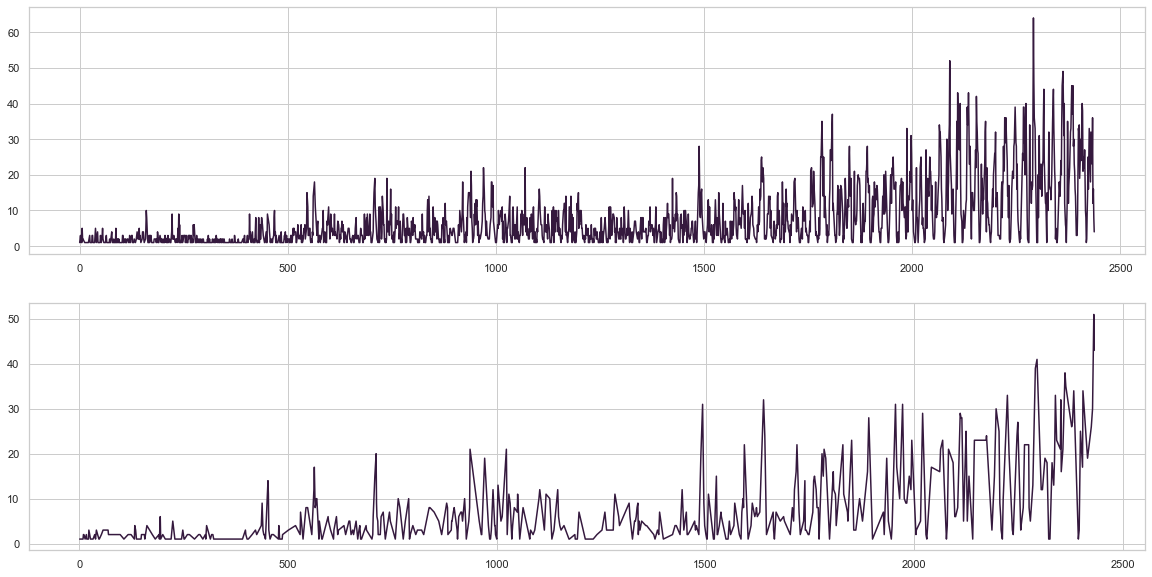

In [63]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
sns.lineplot(data=y_train, ax=ax1)
sns.lineplot(data=y_test, ax=ax2)

## Model: Histogram Gradient Boosting regression

In [115]:
### optimal histogram Gradient boosting results Bremen
# Histogram Gradient Boosting Regression, hourly
# Training splits: Training set  0.78 , Test set:  0.21999999999999997
# Features:  ['hour', 'month', 'avg_temp', 'is_windy', 'is_rainy', 'is_weekday', 'is_peaktime', 'is_dark']
# The R^2  of boosting regression is:  0.7655507952033939
# The MAE  of boosting regression is:  4.66016110300944
# The MSE  of boosting regression is:  42.19256538230443
# The RMSE of boosting regression is:  6.495580449990935

In [114]:
### optimal histogram Gradient boosting results Düsseldorf
# Histogram Gradient Boosting Regression, hourly
# Training splits: Training set  0.65 , Test set:  0.35
# Features:  ['month', 'day', 'hour', 'avg_temp', 'avg_wind', 'avg_rain', 'avg_distance', 'is_weekday', 'is_peaktime', 'is_dark', 'is_rainy', 'is_windy']
# The R^2  of Histogram Gradient boosting regression is:  0.7411808660544513
# The MAE  of Histogram Gradient boosting regression is:  2.7880786787611775
# The MSE  of Histogram Gradient boosting regression is:  18.741496788001424
# The RMSE of Histogram Gradient boosting regression is:  4.329145041229437

In [174]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor

## Histogram gradient Boosting
est = HistGradientBoostingRegressor(max_iter=72, l2_regularization=0.25).fit(X_train, y_train)
est.score(X_train, y_train)

# prediction on test data
y_pred_boost = est.predict(X_test)

# evaluate
r2_boost = r2_score(y_test, y_pred_boost)
MAE_boost =  mean_absolute_error(y_test, y_pred_boost)
MSE_boost = mean_squared_error(y_test, y_pred_boost, squared = True)
RMSE_boost = mean_squared_error(y_test, y_pred_boost, squared = False)

print (f'Histogram Gradient Boosting Regression, {TIME_FRAME}ly')
print ("Training splits: Training set ", SPLIT_TRAIN, ", Test set: ",1-SPLIT_TRAIN)
print ("Features: ", features)
print ('The R^2  of Histogram Gradient boosting regression is: ', r2_boost)
print ('The MAE  of Histogram Gradient boosting regression is: ', MAE_boost)
print ('The MSE  of Histogram Gradient boosting regression is: ', MSE_boost)
print ('The RMSE of Histogram Gradient boosting regression is: ', RMSE_boost)

Histogram Gradient Boosting Regression, hourly
Training splits: Training set  0.95 , Test set:  0.050000000000000044
Features:  ['hour', 'month', 'avg_temp', 'avg_wind', 'is_weekday', 'is_peaktime', 'is_dark']
The R^2  of Histogram Gradient boosting regression is:  0.6855234719699327
The MAE  of Histogram Gradient boosting regression is:  3.4722166782148003
The MSE  of Histogram Gradient boosting regression is:  24.682139494255605
The RMSE of Histogram Gradient boosting regression is:  4.96811226667188


## Model: Gradient Boosting Regression

In [116]:
# optimal gradient boosting results Bremen
# Gradient Boosting Regression, hourly
# Training splits: Training set  0.8 , Test set:  0.19999999999999996
# Features:  ['hour', 'month', 'avg_temp', 'is_windy', 'is_rainy', 'is_weekday', 'is_peaktime', 'is_dark']
# The R^2  of boosting regression is:  0.7352673020222462
# The MAE  of boosting regression is:  4.963996291277663
# The MSE  of boosting regression is:  47.934768056570746
# The RMSE of boosting regression is:  6.923493919732345

In [124]:
# optimal gradient boosting results Düsseldorf
# Gradient Boosting Regression, hourly
# Training splits: Training set  0.65 , Test set:  0.35
# Features:  ['month', 'day', 'hour', 'avg_temp', 'avg_wind', 'avg_rain', 'avg_distance', 'is_weekday', 'is_peaktime', 'is_dark', 'is_rainy', 'is_windy']
# The R^2  of Gradient boosting regression is:  0.7258787397115822
# The MAE  of Gradient boosting regression is:  2.9139391757316653
# The MSE  of Gradient boosting regression is:  19.84954760067746
# The RMSE of Gradient boosting regression is:  4.455283111170092

In [123]:
## Gradient Boosting
reg = GradientBoostingRegressor(n_estimators=450,loss='ls')
reg.fit(X_train, y_train)

# prediction on test data
y_pred_reg = reg.predict(X_test)

# evaluate
r2_reg = r2_score(y_test, y_pred_reg)
MAE_reg =  mean_absolute_error(y_test, y_pred_reg)
MSE_reg = mean_squared_error(y_test, y_pred_reg, squared = True)
RMSE_reg = mean_squared_error(y_test, y_pred_reg, squared = False)

print (f'Gradient Boosting Regression, {TIME_FRAME}ly')
print ("Training splits: Training set ", SPLIT_TRAIN, ", Test set: ",1-SPLIT_TRAIN)
print ("Features: ", features)
print ('The R^2  of Gradient boosting regression is: ', r2_reg)
print ('The MAE  of Gradient boosting regression is: ', MAE_reg)
print ('The MSE  of Gradient boosting regression is: ', MSE_reg)
print ('The RMSE of Gradient boosting regression is: ', RMSE_reg)

Gradient Boosting Regression, hourly
Training splits: Training set  0.65 , Test set:  0.35
Features:  ['month', 'day', 'hour', 'avg_temp', 'avg_wind', 'avg_rain', 'avg_distance', 'is_weekday', 'is_peaktime', 'is_dark', 'is_rainy', 'is_windy']
The R^2  of Gradient boosting regression is:  0.7258787397115822
The MAE  of Gradient boosting regression is:  2.9139391757316653
The MSE  of Gradient boosting regression is:  19.84954760067746
The RMSE of Gradient boosting regression is:  4.455283111170092


In [68]:
def plot_results(predictions):
    fig, axes = plt.subplots(nrows=len(features), ncols=1, figsize=(15, 40))

    for i in range(0,len(features)):
        axes[i].scatter(X_train[features[i]],y_train, marker='x', color='b')
        axes[i].scatter(X_test[features[i]],predictions, marker='x', color='r')
        axes[i].set_xlabel(features[i])
        axes[i].set_ylabel("Demand")
        axes[i].legend(["Training Set", 'Prediction Set'])

## Model: Linear regression

In [129]:
### optimal results linear regression, Bremen
# Linear Regression, hourly
# Training splits: Training set  0.8 , Test set:  0.19999999999999996
# Features:  ['hour', 'month', 'avg_temp', 'avg_wind', 'is_weekday', 'is_peaktime', 'is_dark']
# The R^2  of linear regression is:  0.5954784535942184
# The MAE  of linear regression is:  6.548339160910814
# The MSE  of linear regression is:  73.24613336005783
# The RMSE of linear regression is:  8.55839548981337

In [176]:
### optimal results linear regression, Düsseldorf
# Linear Regression, hourly
# Training splits: Training set  0.95 , Test set:  0.050000000000000044
# Features:  ['hour', 'month', 'avg_temp', 'avg_wind', 'is_weekday', 'is_peaktime', 'is_dark']
# The R^2  of linear regression is:  0.5722060036041494
# The MAE  of linear regression is:  4.357207584244507
# The MSE  of linear regression is:  33.576022859289274
# The RMSE of linear regression is:  5.794482104492969

Linear Regression, hourly
Training splits: Training set  0.95 , Test set:  0.050000000000000044
Features:  ['hour', 'month', 'avg_temp', 'avg_wind', 'is_weekday', 'is_peaktime', 'is_dark']
The R^2  of linear regression is:  0.5722060036041494
The MAE  of linear regression is:  4.357207584244507
The MSE  of linear regression is:  33.576022859289274
The RMSE of linear regression is:  5.794482104492969


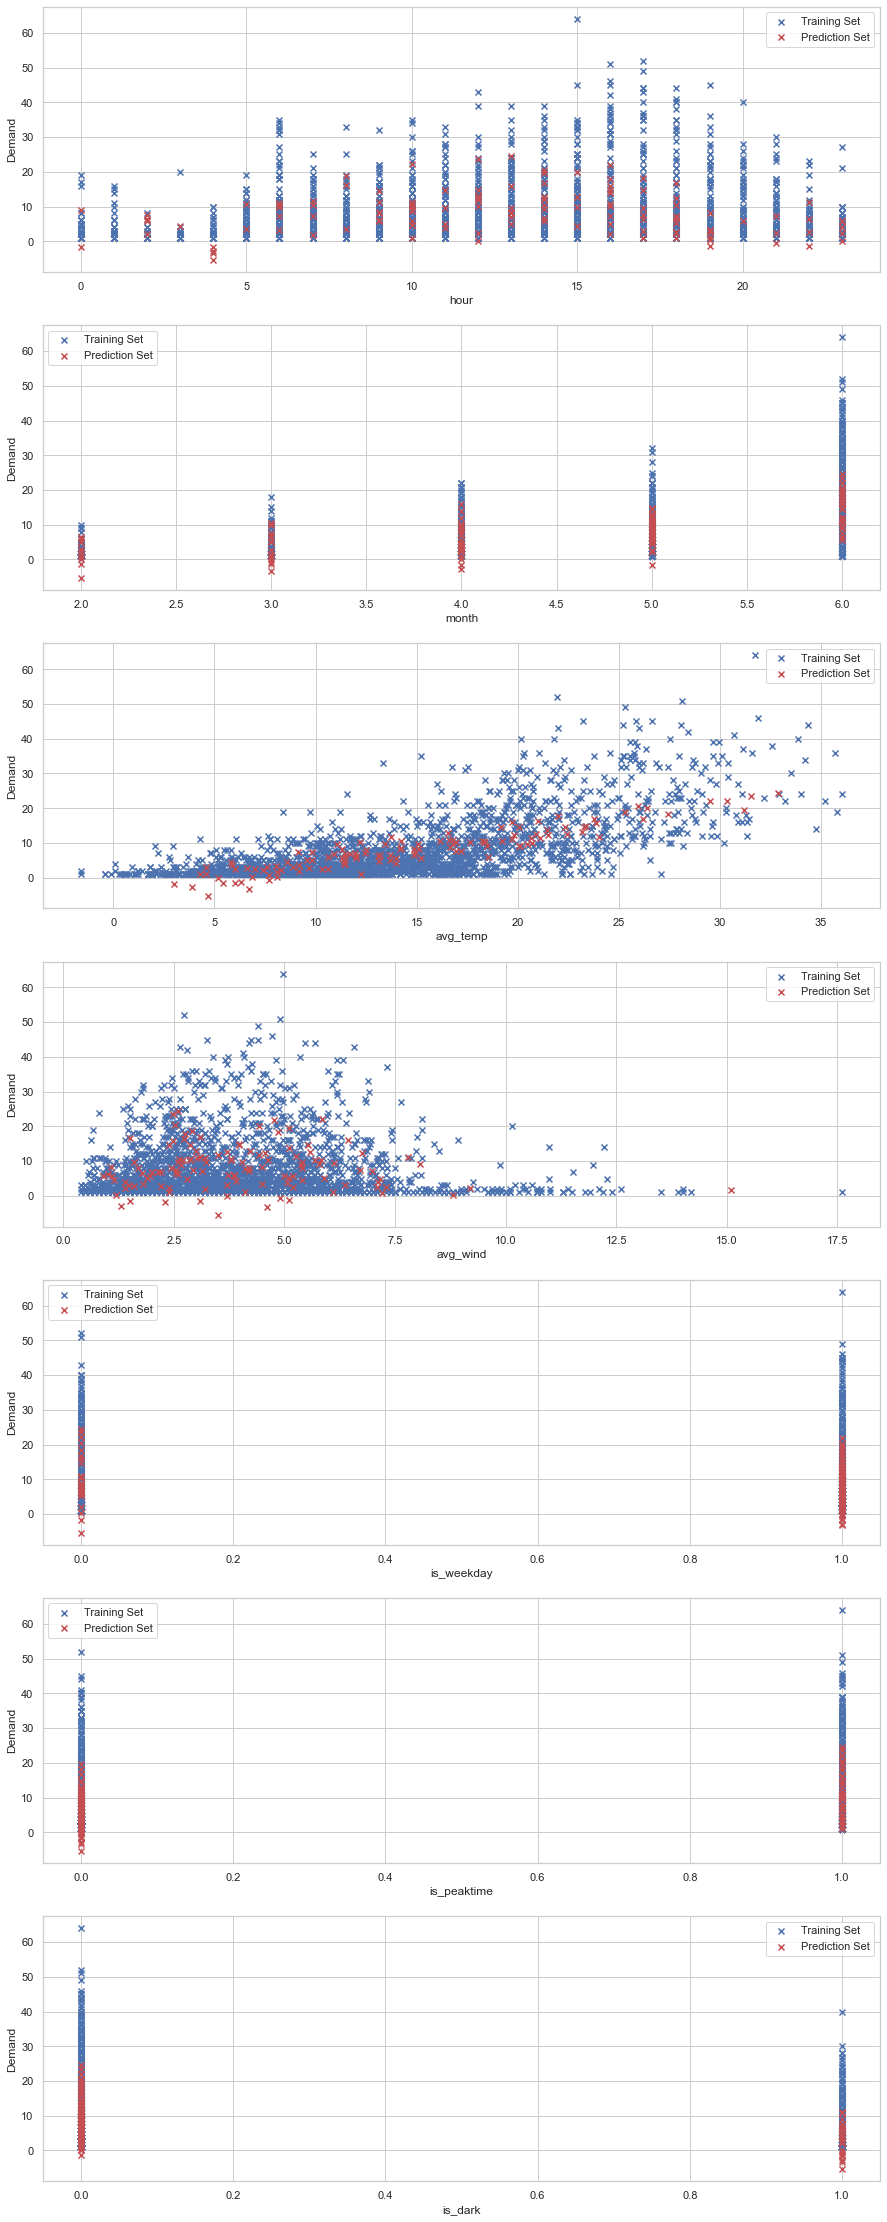

In [175]:
# fit model on training data
model_lin = LinearRegression(normalize = True)
model_lin.fit(X_train, y_train)

# prediction on test data
y_pred_lin = model_lin.predict(X_test)

# evaluate
r2_lin = r2_score(y_test, y_pred_lin)
MAE_lin =  mean_absolute_error(y_test, y_pred_lin)
MSE_lin = mean_squared_error(y_test, y_pred_lin, squared = True)
RMSE_lin = mean_squared_error(y_test, y_pred_lin, squared = False)

print (f'Linear Regression, {TIME_FRAME}ly')
print ("Training splits: Training set ", SPLIT_TRAIN, ", Test set: ",1-SPLIT_TRAIN)
print ("Features: ", features)
print ('The R^2  of linear regression is: ', r2_lin)
print ('The MAE  of linear regression is: ', MAE_lin)
print ('The MSE  of linear regression is: ', MSE_lin)
print ('The RMSE of linear regression is: ', RMSE_lin)
#print("Coefficients ", model.coef_, "\nIntercept ", model.intercept_ )
plot_results(y_pred_lin)

## Model 1: polynomial regression with normalization without regularization

### select best degree

0.7332516318048576  , degree:  4


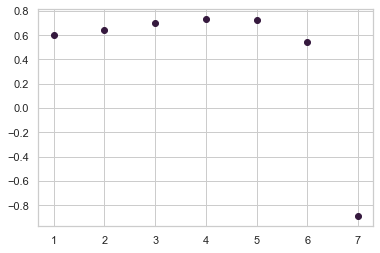

In [150]:
degree_range = range(1,8)
def polynomial_get_degrees():
    r2 = []
    for i in degree_range:
        # generate and transform polynomial features
        poly1 = PolynomialFeatures (degree = i)
        x_poly1 = poly1.fit_transform(np.array(X_train).reshape(y_train.shape[0],-1))
            
        # fit model on training data
        model = LinearRegression(normalize = True)
        model.fit(x_poly1, y_train)

        # prediction on training data
        y_pred1 = model.predict(poly1.fit_transform(np.array(X_test).reshape(y_test.shape[0],-1)))
        
        # calc r2 score
        r2_1 = r2_score(y_test, y_pred1)
        r2.append(r2_1)
    return r2

score_per_degree = polynomial_get_degrees()
best_degree = np.array(score_per_degree).argmax()+1
print (np.array(score_per_degree).max()," , degree: ", best_degree)
plt.scatter(x=degree_range, y=score_per_degree)
model_degree = best_degree

### train and evaluate model 1: polynomial regression

In [ ]:
### optimal results polynomial regression, Bremen
# Polynomial Regression, hourly, degree: 4
# Training splits: Training set  0.8 , Test set:  0.19999999999999996
# Features:  ['hour', 'month', 'avg_temp', 'avg_wind', 'is_weekday', 'is_peaktime', 'is_dark']
# The R^2  of polynomial regression is:  0.7332516318048576
# The MAE  of polynomial regression is:  5.114255564553397
# The MSE  of polynomial regression is:  48.299742557594335
# The RMSE of polynomial regression is:  6.949801620017245

In [144]:
### optimal results polynomial regression, Düsseldorf
# Polynomial Regression, hourly, degree: 2
# Training splits: Training set  0.65 , Test set:  0.35
# Features:  ['hour', 'month', 'avg_temp', 'avg_wind', 'is_weekday', 'is_peaktime', 'is_dark']
# The R^2  of polynomial regression is:  0.6600175313454395
# The MAE  of polynomial regression is:  3.4706593182053562
# The MSE  of polynomial regression is:  24.61866032519358
# The RMSE of polynomial regression is:  4.96171949279618

Polynomial Regression, hourly, degree: 4
Training splits: Training set  0.8 , Test set:  0.19999999999999996
Features:  ['hour', 'month', 'avg_temp', 'avg_wind', 'is_weekday', 'is_peaktime', 'is_dark']
The R^2  of polynomial regression is:  0.7332516318048576
The MAE  of polynomial regression is:  5.114255564553397
The MSE  of polynomial regression is:  48.299742557594335
The RMSE of polynomial regression is:  6.949801620017245


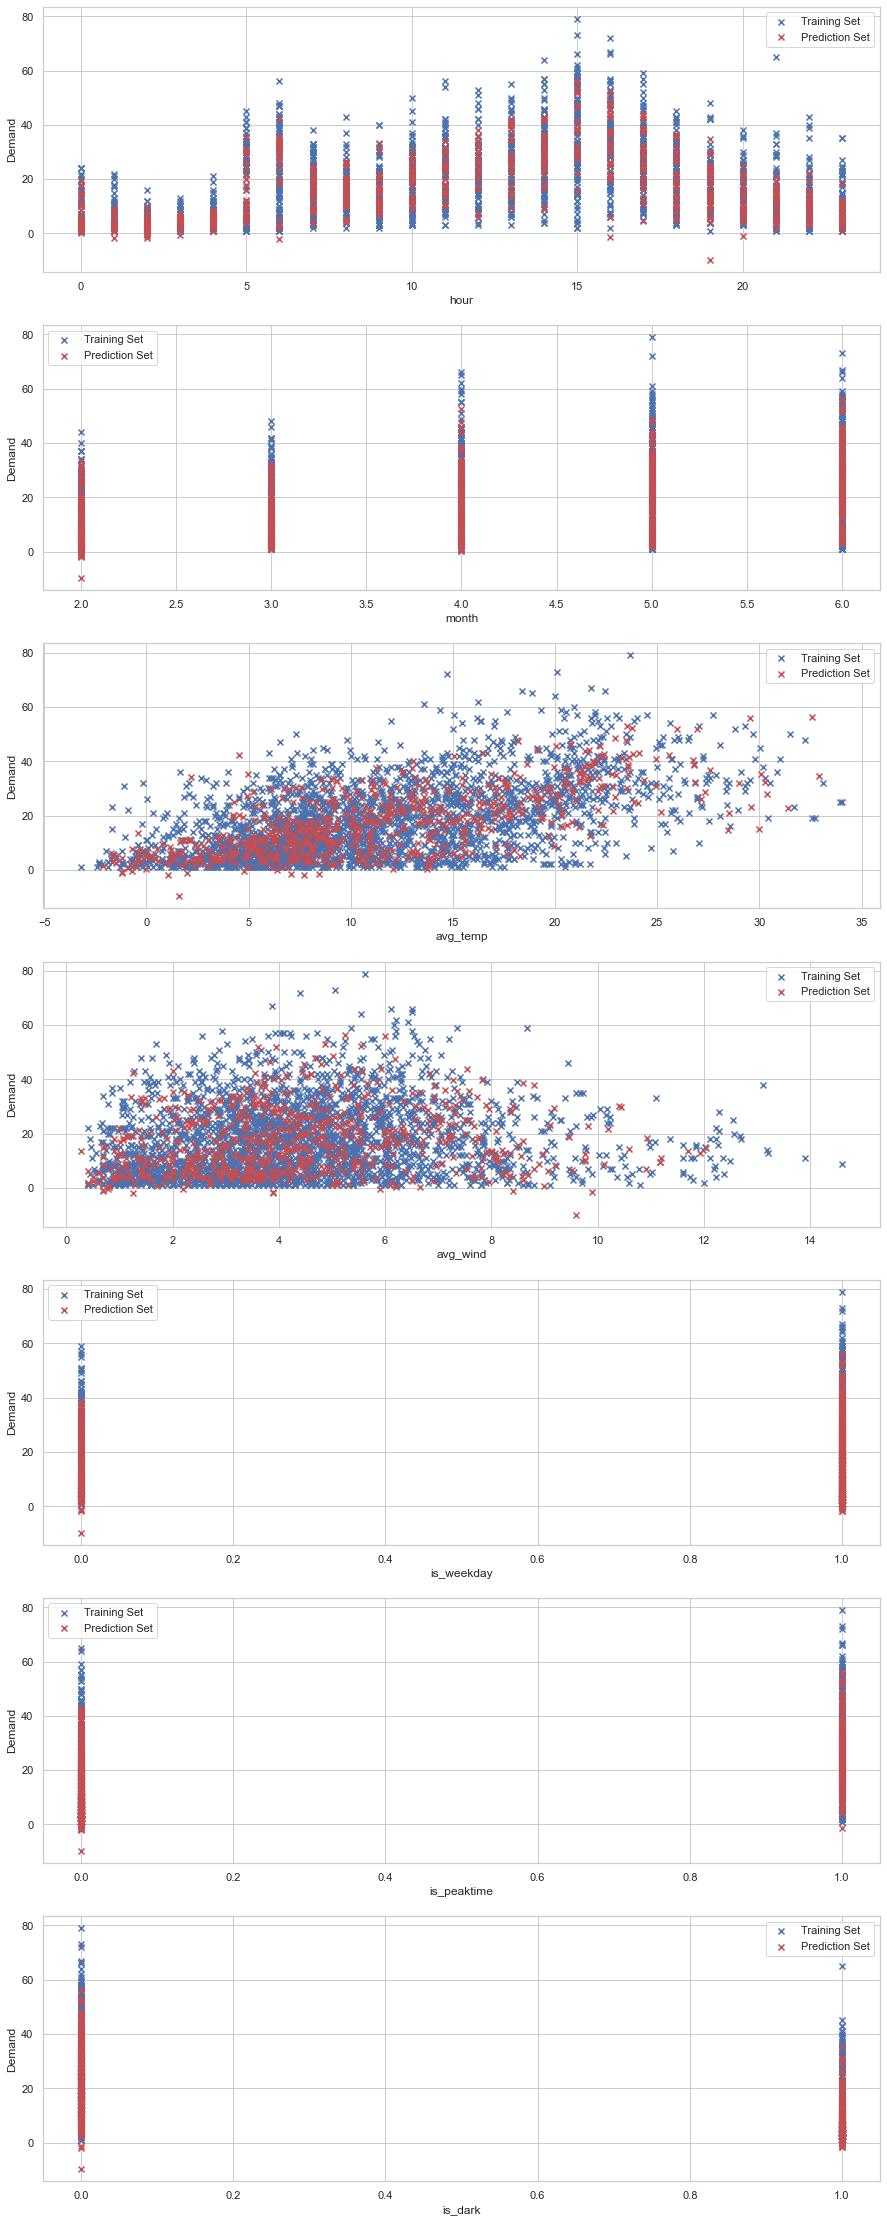

In [151]:
# generate and transform polynomial features
poly1 = PolynomialFeatures (degree = model_degree)
x_poly1 = poly1.fit_transform(np.array(X_train).reshape(y_train.shape[0],-1))

# fit model on training data
model = LinearRegression(normalize = True)
model.fit(x_poly1, y_train)

# prediction on test data
y_pred1 = model.predict(poly1.fit_transform(np.array(X_test).reshape(y_test.shape[0],-1)))

# evaluate
r2_1 = r2_score(y_test, y_pred1)
MAE_1 =  mean_absolute_error(y_test, y_pred1)
MSE_1 = mean_squared_error(y_test, y_pred1, squared = True)
RMSE_1 = mean_squared_error(y_test, y_pred1, squared = False)

print (f'Polynomial Regression, {TIME_FRAME}ly, degree: {model_degree}')
print ("Training splits: Training set ", SPLIT_TRAIN, ", Test set: ",1-SPLIT_TRAIN)
print ("Features: ", features)
print ('The R^2  of polynomial regression is: ', r2_1)
print ('The MAE  of polynomial regression is: ', MAE_1)
print ('The MSE  of polynomial regression is: ', MSE_1)
print ('The RMSE of polynomial regression is: ', RMSE_1)
#print("Coefficients ", model.coef_, "\nIntercept ", model.intercept_ )
plot_results(y_pred1)

## Model 2: Ridge regression

In [72]:
from sklearn.linear_model import Ridge

### select best degree

0.7147721214620555  , degree:  7


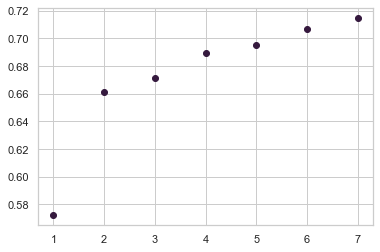

In [177]:
degree_range_L2 = range(1,8)
def polynomial_get_degrees_L2(al):
    r2 = []
    for i in degree_range_L2:
        # generate and transform polynomial features
        poly2 = PolynomialFeatures(degree = i)
        x_poly2 = poly2.fit_transform(np.array(X_train).reshape(y_train.shape[0],-1))

        # fit model on training data
        model_L2 = Ridge(alpha = al, normalize=True, solver = 'lsqr')
        model_L2.fit(x_poly2, y_train)

        # prediction on test data
        y_pred2 = model_L2.predict(poly2.fit_transform(np.array(X_test).reshape(y_test.shape[0],-1)))

        # calc r2 score
        r2_2 = r2_score(y_test, y_pred2)
        r2.append(r2_2)
    return r2

alpha_L2 = 0.001
score_per_degree_L2 = polynomial_get_degrees_L2(alpha_L2)
best_degree_L2 = np.array(score_per_degree_L2).argmax()+1
print (np.array(score_per_degree_L2).max()," , degree: ", best_degree_L2)
plt.scatter(x=degree_range_L2, y=score_per_degree_L2)
model_L2_degree = best_degree_L2

### train and evaluate model 2: ridge regression

In [161]:
### optimal results ridge regression, Bremen
# Ridge Regression, hourly, lambda: 0.001, optimal degree: 7
# Training splits: Training set  0.8 , Test set:  0.19999999999999996
# Features:  ['hour', 'month', 'avg_temp', 'avg_wind', 'is_weekday', 'is_peaktime', 'is_dark']
# The R^2  of ridge regression is:  0.7134682659507011
# The MAE  of ridge regression is:  5.308258626324611
# The MSE  of ridge regression is:  51.8818880985164
# The RMSE of ridge regression is:  7.202908308351315

In [179]:
### optimal results ridge regression, Düsseldorf
# Ridge Regression, hourly, lambda: 0.001, optimal degree: 7
# Training splits: Training set  0.95 , Test set:  0.050000000000000044
# Features:  ['hour', 'month', 'avg_temp', 'avg_wind', 'is_weekday', 'is_peaktime', 'is_dark']
# The R^2  of ridge regression is:  0.7147721214620555
# The MAE  of ridge regression is:  3.348186352582339
# The MSE  of ridge regression is:  22.386517460695945
# The RMSE of ridge regression is:  4.731439258903779

Ridge Regression, hourly, lambda: 0.001, optimal degree: 7
Training splits: Training set  0.7 , Test set:  0.30000000000000004
Features:  ['hour', 'month', 'avg_temp', 'avg_wind', 'is_weekday', 'is_peaktime', 'is_dark']
The R^2  of ridge regression is:  0.6662818384002847
The MAE  of ridge regression is:  3.358311178578345
The MSE  of ridge regression is:  24.832793108718363
The RMSE of ridge regression is:  4.983251258838788


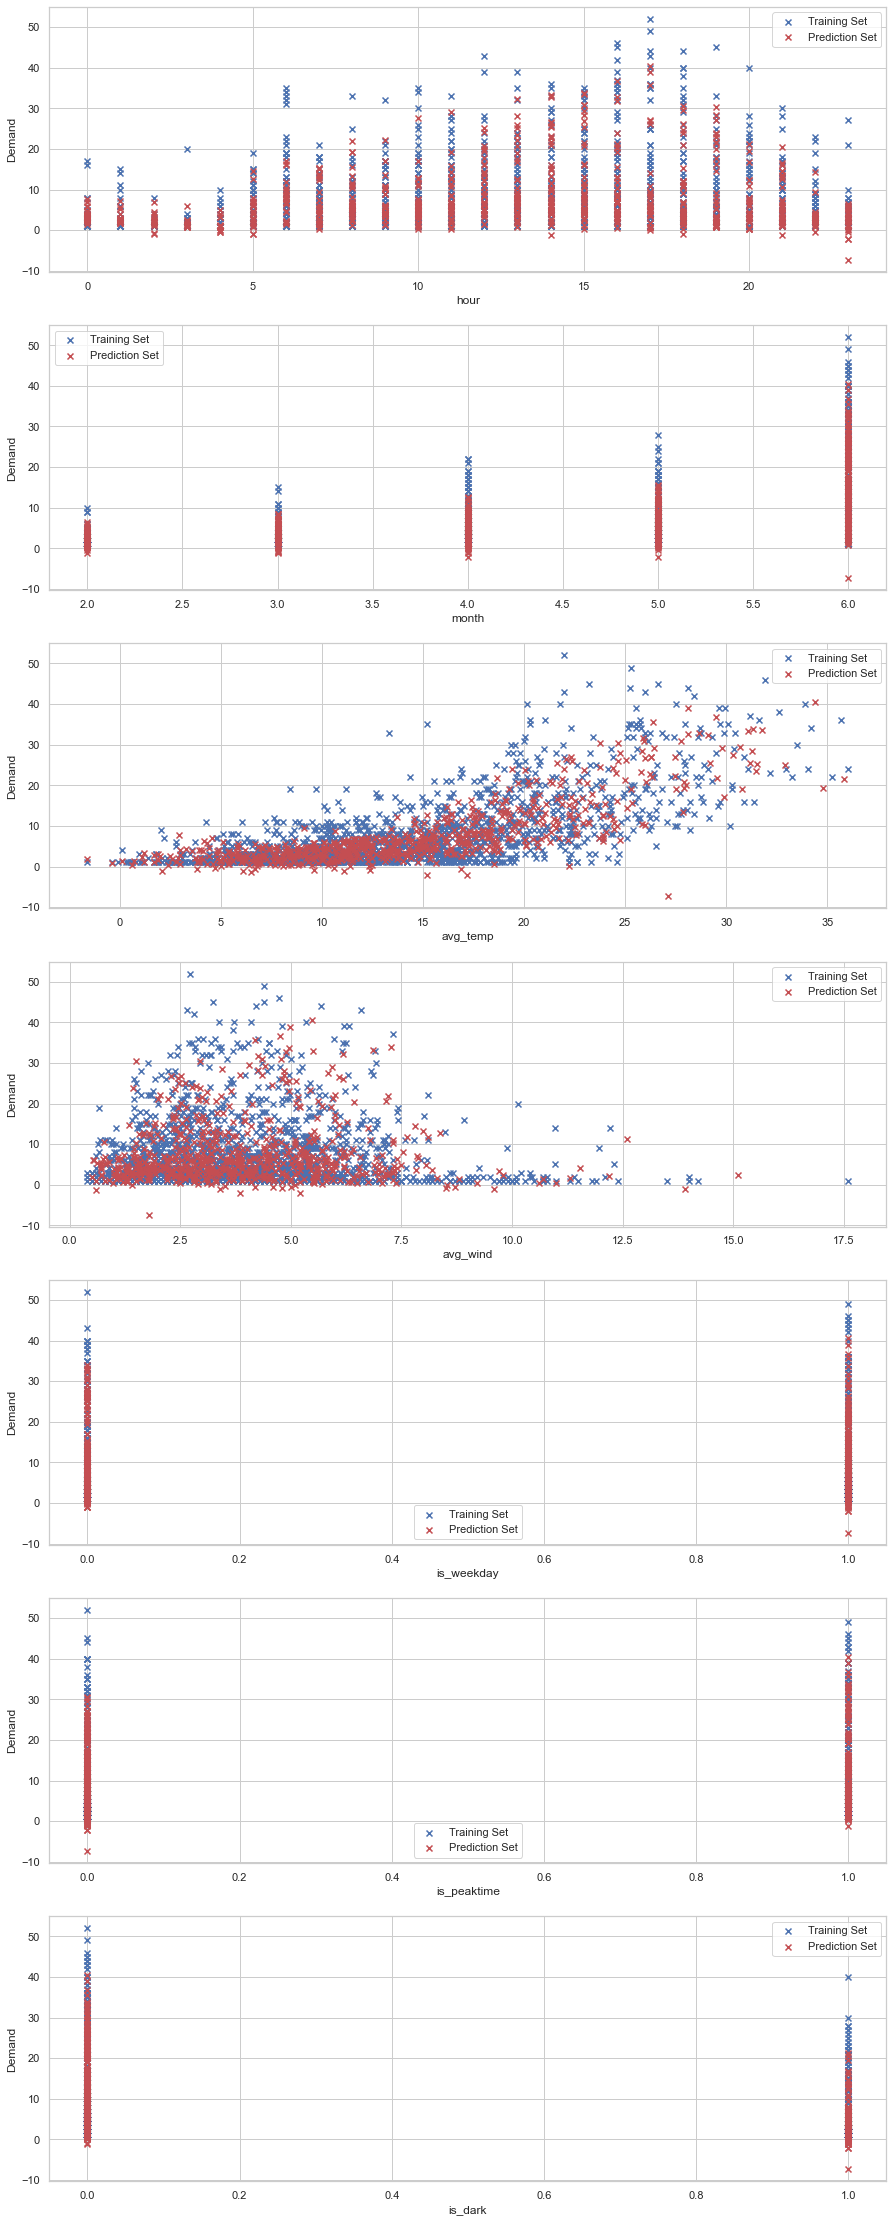

In [181]:
# generate and transform polynomial features
poly2 = PolynomialFeatures(degree = model_L2_degree)
x_poly2 = poly2.fit_transform(np.array(X_train).reshape(y_train.shape[0],-1))

# fit model on training data
model_L2 = Ridge(alpha = alpha_L2, normalize=True, solver = 'lsqr')
model_L2.fit(x_poly2, y_train)

# prediction on test data
y_pred2 = model_L2.predict(poly2.fit_transform(np.array(X_test).reshape(y_test.shape[0],-1)))

# evaluate
r2_2 = r2_score(y_test, y_pred2)
MAE_2 =  mean_absolute_error(y_test, y_pred2)
MSE_2 = mean_squared_error(y_test, y_pred2, squared = True)
RMSE_2 = mean_squared_error(y_test, y_pred2, squared = False)

print (f'Ridge Regression, {TIME_FRAME}ly, lambda: {alpha_L2}, optimal degree: {model_L2_degree}')
print ("Training splits: Training set ", SPLIT_TRAIN, ", Test set: ",1-SPLIT_TRAIN)
print ("Features: ", features)
print ('The R^2  of ridge regression is: ', r2_2)
print ('The MAE  of ridge regression is: ', MAE_2)
print ('The MSE  of ridge regression is: ', MSE_2)
print ('The RMSE of ridge regression is: ', RMSE_2)
#print("Coefficients ", model.coef_, "\nIntercept ", model.intercept_ )
plot_results(y_pred2)

## Model 3: Lasso regression

In [75]:
from sklearn.linear_model import Lasso
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

### select best degree

0.7225101697778884  , degree:  7


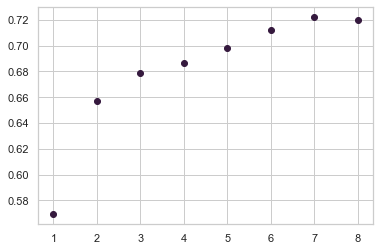

In [183]:
degree_range_L1 = range(1,9)
def polynomial_get_degrees_L1(al):
    r2 = []
    for i in degree_range_L1:
        # generate and transform polynomial features
        poly3 = PolynomialFeatures(degree = i)
        x_poly3 = poly3.fit_transform(np.array(X_train).reshape(y_train.shape[0],-1))

        # fit model on training data
        model_L1 = Lasso(alpha = al, max_iter=1000)
        model_L1.fit(x_poly3, y_train)

        # prediction on test data
        y_pred3 = model_L1.predict(poly3.fit_transform(np.array(X_test).reshape(y_test.shape[0],-1)))

        # calc r2 score
        r2_3 = r2_score(y_test, y_pred3)
        r2.append(r2_3)
    return r2

alpha_L1 = 0.1
score_per_degree_L1 = polynomial_get_degrees_L1(alpha_L1)
best_degree_L1 = np.array(score_per_degree_L1).argmax()+1
print (np.array(score_per_degree_L1).max()," , degree: ", best_degree_L1)
plt.scatter(x=degree_range_L1, y=score_per_degree_L1)
model_L1_degree = best_degree_L1

### train and evaluate model 3: lasso regression

In [168]:
### optimal results lasso regression, Bremen
# Lasso Regression, hourly, lambda: 0.1, optimal degree: 7
# Features:  ['hour', 'month', 'avg_temp', 'avg_wind', 'is_weekday', 'is_peaktime', 'is_dark']
# The R^2  of lasso regression is:  0.7164915788659026
# The MAE  of lasso regression is:  5.252409613289386
# The MSE  of lasso regression is:  51.33446118654197
# The RMSE of lasso regression is:  7.164807128356071

In [186]:
### optimal results lasso regression, Düsseldorf
# Lasso Regression, hourly, lambda: 0.1, optimal degree: 7
# Features:  ['hour', 'month', 'avg_temp', 'avg_wind', 'is_weekday', 'is_peaktime', 'is_dark']
# The R^2  of lasso regression is:  0.7225101697778884
# The MAE  of lasso regression is:  3.291866563147094
# The MSE  of lasso regression is:  21.779185685758467
# The RMSE of lasso regression is:  4.666817511512366

Lasso Regression, hourly, lambda: 0.1, optimal degree: 7
Features:  ['hour', 'month', 'avg_temp', 'avg_wind', 'is_weekday', 'is_peaktime', 'is_dark']
The R^2  of lasso regression is:  0.7225101697778884
The MAE  of lasso regression is:  3.291866563147094
The MSE  of lasso regression is:  21.779185685758467
The RMSE of lasso regression is:  4.666817511512366


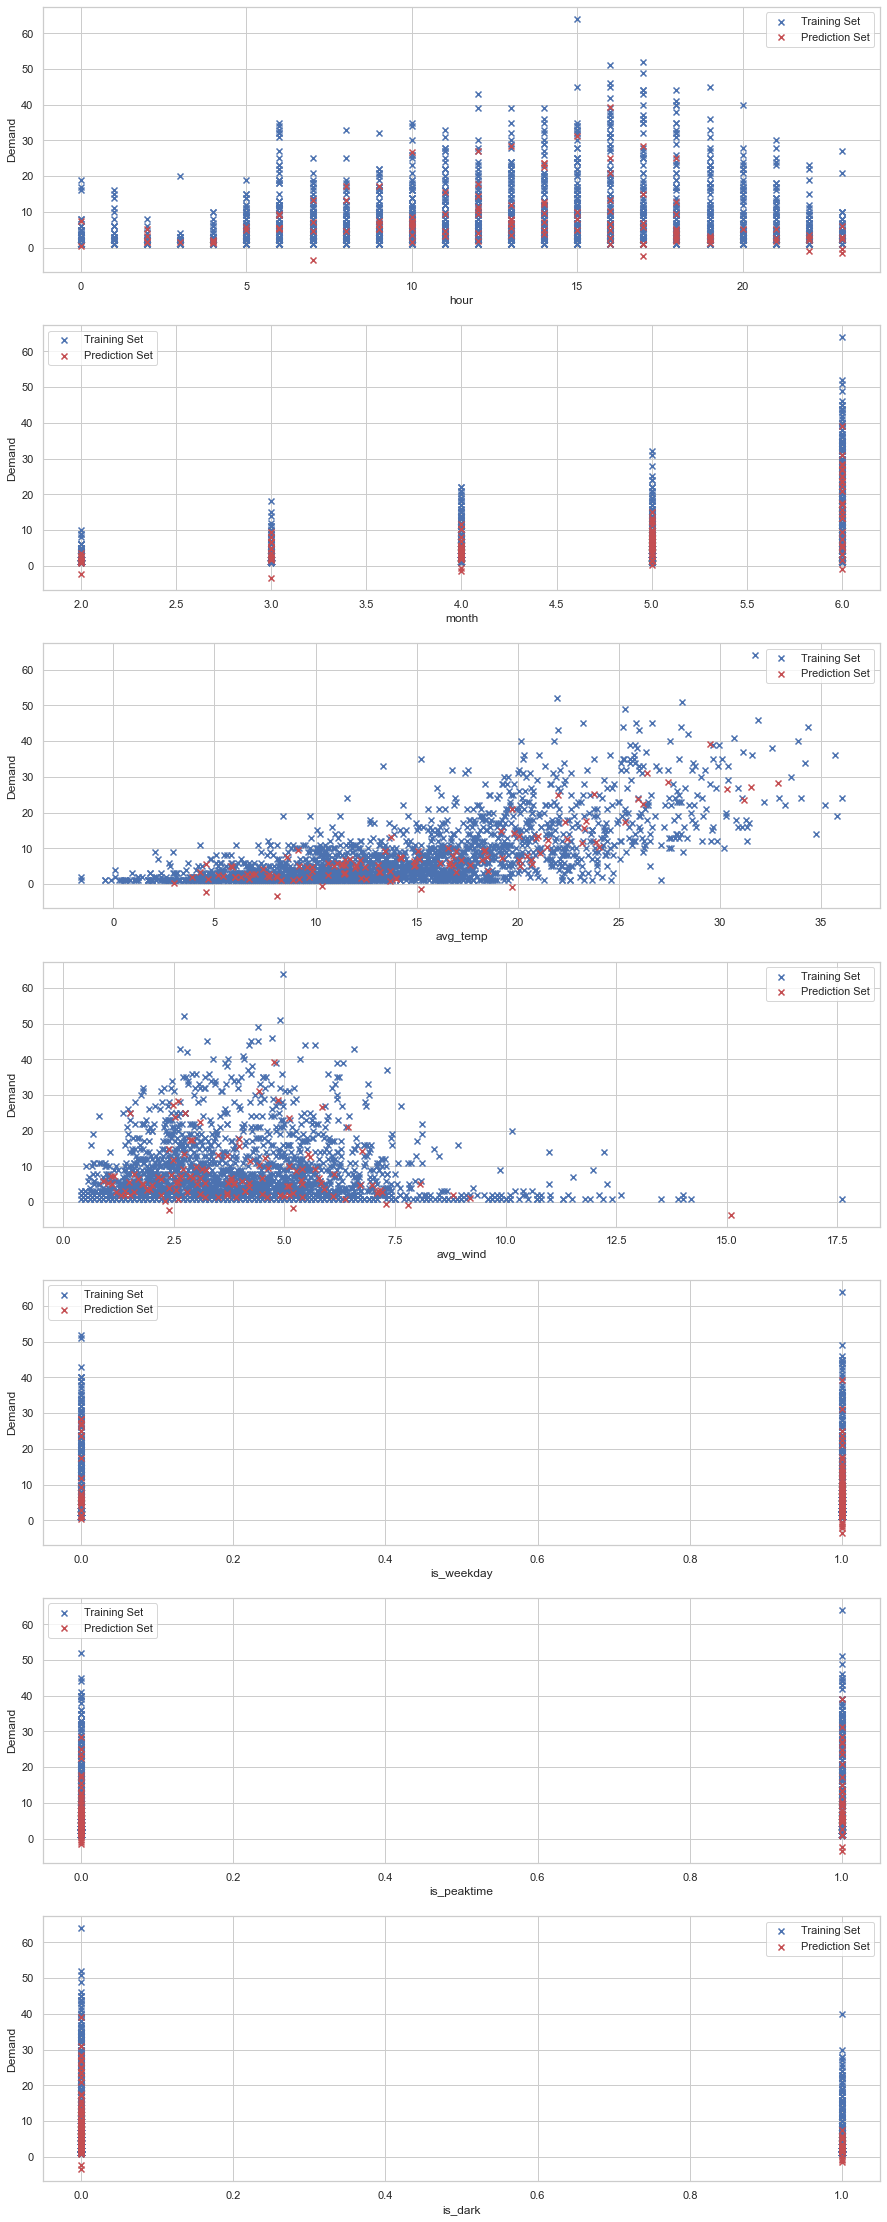

In [185]:
# generate and transform polynomial features
poly3 = PolynomialFeatures(degree = model_L1_degree)
x_poly3 = poly3.fit_transform(np.array(X_train).reshape(y_train.shape[0],-1))

# fit model on training data
model_L1 = Lasso(alpha = alpha_L1, max_iter=1000)
model_L1.fit(x_poly3, y_train)

# prediction on test data
y_pred3 = model_L1.predict(poly3.fit_transform(np.array(X_test).reshape(y_test.shape[0],-1)))

# evaluate on three metrics
r2_3 = r2_score(y_test, y_pred3)
MAE_3 =  mean_absolute_error(y_test, y_pred3)
MSE_3 = mean_squared_error(y_test, y_pred3, squared = True)
RMSE_3 = mean_squared_error(y_test, y_pred3, squared = False)

print (f'Lasso Regression, {TIME_FRAME}ly, lambda: {alpha_L1}, optimal degree: {model_L1_degree}')
print ("Features: ", features)
print ('The R^2  of lasso regression is: ', r2_3)
print ('The MAE  of lasso regression is: ', MAE_3)
print ('The MSE  of lasso regression is: ', MSE_3)
print ('The RMSE of lasso regression is: ', RMSE_3)
#print("Coefficients ", model.coef_, "\nIntercept ", model.intercept_ )
plot_results(y_pred3)

## Model 4: Random Forest Regression

In [184]:
from sklearn.ensemble import RandomForestRegressor
reg_rf = RandomForestRegressor(max_depth=2, random_state=0)
reg_rf.fit(X_train, y_train)

# prediction on test data
y_pred_reg_rf = reg_rf.predict(X_test)

# evaluate
r2_reg_rf = r2_score(y_test, y_pred_reg_rf)
MAE_reg_rf =  mean_absolute_error(y_test, y_pred_reg_rf)
MSE_reg_rf = mean_squared_error(y_test, y_pred_reg_rf, squared = True)
RMSE_reg_rf = mean_squared_error(y_test, y_pred_reg_rf, squared = False)

print (f'Random Forest Regression, {TIME_FRAME}ly')
print ("Training splits: Training set ", SPLIT_TRAIN, ", Test set: ",1-SPLIT_TRAIN)
print ("Features: ", features)
print ('The R^2  of Random Forest regression is: ', r2_reg_rf)
print ('The MAE  of Random Forest regression is: ', MAE_reg_rf)
print ('The MSE  of Random Forest regression is: ', MSE_reg_rf)
print ('The RMSE of Random Forest regression is: ', RMSE_reg_rf)


Random Forest Regression, hourly
Training splits: Training set  0.95 , Test set:  0.050000000000000044
Features:  ['hour', 'month', 'avg_temp', 'avg_wind', 'is_weekday', 'is_peaktime', 'is_dark']
The R^2  of Random Forest regression is:  0.5686578810984464
The MAE  of Random Forest regression is:  4.388781836693833
The MSE  of Random Forest regression is:  33.854502322214714
The RMSE of Random Forest regression is:  5.818462195650558


***
# Results for hourly demand prediction, Bremen

## Three Best Prediction models:
### Histogram Gradient Boosting regression
For training and test splits of 78% and 22% and features ['hour', 'month', 'avg_temp', 'is_windy', 'is_rainy', 'is_weekday', 'is_peaktime', 'is_dark'] it yielded following results: 
- The R^2  of Histogram gradient boosting regression is:  0.7655507952033939
- The MAE  of Histogram gradient boosting regression is:  4.66016110300944
- The MSE  of Histogram gradient boosting regression is:  42.19256538230443
- The RMSE of Histogram gradient boosting regression is:  6.49558044999093

### Gradient Boosting regression
For training and test splits of 80% and 20% and features ['hour', 'month', 'avg_temp', 'is_windy', 'is_rainy', 'is_weekday', 'is_peaktime', 'is_dark'] it yielded following results:
- The R^2  of boosting regression is:  0.7352673020222462
- The MAE  of boosting regression is:  4.963996291277663
- The MSE  of boosting regression is:  47.934768056570746
- The RMSE of boosting regression is:  6.923493919732345

### Polynomial Regression
For training and test splits of 80% and 20%, polynomial degree of 4 and features ['hour', 'month', 'avg_temp', 'avg_wind', 'is_weekday', 'is_peaktime', 'is_dark'] it yielded following results:
- The R^2  of polynomial regression is:  0.7332516318048576
- The MAE  of polynomial regression is:  5.114255564553397
- The MSE  of polynomial regression is:  48.299742557594335
- The RMSE of polynomial regression is:  6.949801620017245

## General explanation of results
The best prediction model, using histogram gradient boosting regression, yielded an r^2 score of roughly 76,55%, which means that the model could explain or predict about 3/4 of the provided data and its variance. The Mean Absolute Error of 4,66 Units indicates that the model could predict hourly bike rental demand with a mean deviation of +- 4,66 rentals. The MSE of 42,19 Units and RMSE of 6,49 Units indicate that there are some higher deviations of predicted rental demand when compared to the MAE of 4,66. Higher deviations are obviously undesirable, but due to the highly variable nature of bike rental demand we assume the model performance to be bound by the provided data, which also contains high deviations.

## Implications
As the correlation analyis and prediction results suggest, we found evidence for some fairly obvious, but mostly anecdotal statements:
- The bike rental demand rises as the temperature increases, which can be observed when summer months are approached
- The hour of day matters for predicting the demand, since there are peak rental times (morning and afternoon hours), as well as lower rental demand in dark/night hours
- The weather is highly influencing bike rental demand, with rain and wind reducing the number of rented bikes
- The number of bike rentals is higher in the inner city
- The bike rental demand varies between weekdays and weekends

Based on this evidence, nextBike can optimize its service, especially the size of operating fleet, by incorporating said factors into their calculations. That could mean they set up a higher number of stations in the inner city, or try to increase their fleet size dramatically when the summer months are approaching. Another approach could be to react on weather forecast, because a drought could be accompanied by increased rental demand. Also the variance of demand between distinct hours of day and between weekdays and weekends open up opportunities to adjust their fleet dynamically, reducing the operation cost to the minimum.

## Possible Improvement 
The most important and promising improvement lever for futre projects is a more detailed selection of features. The comparison of boosting regressors with the other regression types suggests that a thorough analysis of weather data resulting in categorical weather features could yield even better results. As the boosting regressors have shown similar or worse results in comparison to the other regression types (polynomial, ridge, lasso) on the same features, including continuous weather data, they are comparably better when using simple categorical weather features indicating bad weather (is_windy, is_rainy). Also, the is_dark and hour features could be improved when integrating the fact that days get longer in the summer up to a certain maximum and then getting shorter again, which certainly has an impact on the rentals, as the feature is_dark suggests.

***
# Results for hourly demand prediction, Düsseldorf

## Three Best Prediction models:
### Histogram Gradient Boosting regression
For training and test splits of 65% and 35% and features ['month', 'day', 'hour', 'avg_temp', 'avg_wind', 'avg_rain', 'avg_distance', 'is_weekday', 'is_peaktime', 'is_dark', 'is_rainy', 'is_windy'] it yielded following results: 
- The R^2  of Histogram Gradient boosting regression is:  0.7411808660544513
- The MAE  of Histogram Gradient boosting regression is:  2.7880786787611775
- The MSE  of Histogram Gradient boosting regression is:  18.741496788001424
- The RMSE of Histogram Gradient boosting regression is:  4.329145041229437

### Gradient Boosting regression
For training and test splits of 65% and 36% and features ['month', 'day', 'hour', 'avg_temp', 'avg_wind', 'avg_rain', 'avg_distance', 'is_weekday', 'is_peaktime', 'is_dark', 'is_rainy', 'is_windy'] it yielded following results:
- The R^2  of Gradient boosting regression is:  0.7258787397115822
- The MAE  of Gradient boosting regression is:  2.9139391757316653
- The MSE  of Gradient boosting regression is:  19.84954760067746
- The RMSE of Gradient boosting regression is:  4.455283111170092

### Lasso Regression
For training and test splits of 80% and 20%, polynomial degree of 7, lambda = 0.1 and features ['hour', 'month', 'avg_temp', 'avg_wind', 'is_weekday', 'is_peaktime', 'is_dark'] it yielded following results:
- The R^2  of lasso regression is:  0.7225101697778884
- The MAE  of lasso regression is:  3.291866563147094
- The MSE  of lasso regression is:  21.779185685758467
- The RMSE of lasso regression is:  4.666817511512366

## General explanation of results
The best prediction model, using histogram gradient boosting regression, yielded an r^2 score of roughly 74,11%, which means that the model could explain or predict about 3/4 of the provided data and its variance. The Mean Absolute Error of 2.78 Units indicates that the model could predict hourly bike rental demand with a mean deviation of +- 2.78 rentals. The MSE of 18.74 Units and RMSE of 4.32 Units indicate that there are some higher deviations of predicted rental demand when compared to the MAE of 2.78. Higher deviations are obviously undesirable, but due to the highly variable nature of bike rental demand we assume the model performance to be bound by the provided data, which also contains high deviations.

Also, the lower values for MAE, MSE and RMSE in Düsseldorf are most likely due to the fact that there are fewer data points in the Düsseldorf data set, which means there are less deviating values from the regression line.

## Implications
As the correlation analyis and prediction results suggest, we found evidence for some fairly obvious, but mostly anecdotal statements:
- The bike rental demand rises as the temperature increases, which can be observed when summer months are approached
- The hour of day matters for predicting the demand, since there are peak rental times (morning and afternoon hours), as well as lower rental demand in dark/night hours
- The weather is highly influencing bike rental demand, with rain and wind reducing the number of rented bikes
- The number of bike rentals is higher in the inner city
- The bike rental demand varies between weekdays and weekends

Based on this evidence, nextBike can optimize its service, especially the size of operating fleet, by incorporating said factors into their calculations. That could mean they set up a higher number of stations in the inner city, or try to increase their fleet size dramatically when the summer months are approaching. Another approach could be to react on weather forecast, because a drought could be accompanied by increased rental demand. Also the variance of demand between distinct hours of day and between weekdays and weekends open up opportunities to adjust their fleet dynamically, reducing the operation cost to the minimum.

## Possible Improvement 
The most important and promising improvement lever for futre projects is a more detailed selection of features. The comparison of boosting regressors with the other regression types suggests that a thorough analysis of weather data resulting in categorical weather features could yield even better results. As the boosting regressors have shown similar or worse results in comparison to the other regression types (polynomial, ridge, lasso) on the same features, including continuous weather data, they are comparably better when using simple categorical weather features indicating bad weather (is_windy, is_rainy). Also, the is_dark and hour features could be improved when integrating the fact that days get longer in the summer up to a certain maximum and then getting shorter again, which certainly has an impact on the rentals, as the feature is_dark suggests.